## **Customer Churn Prediction**

**<span style="color: blue;">Business Understanding</span>**

Train a model to predict the likelihood of a customer leaving the organization, the key indicators of churn as well as the retention strategies that can be implemented to avert this problem.

The likelihood of a customer leaving the organization (churn) is influenced by a combination of factors, including:

1. Demographic characteristics (Gender, SeniorCitizen)
2. Account characteristics (Tenure, Phone Service, MultipleLines, InternetService)
3. Service features (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies)
4. Billing and payment characteristics (Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges)


**Hypothesis**

**Null Hypothesis (H0):**

There is no significant relationship between the identified factors (demographic characteristics, account characteristics, service features, and billing and payment characteristics) and customer churn.

**Alternative Hypothesis (H1):**

There is a significant relationship between the identified factors and customer churn, and the likelihood of churn can be predicted by a combination of these factors.



**Questions**

1. Is there a significant difference in churn rates between customers with a tenure of less than 12 months and those with a tenure of 12 months or more?

2. Do customers with online security and backup features have a lower churn rate compared to those without these features?

3. Is there a correlation between monthly charges and churn, and what is the threshold beyond which the likelihood of churn increases significantly?


**Additional Questions**

1. Do customers with multiple lines (MultipleLines = Yes) have a lower churn rate compared to those with a single line?

2. Is there a significant difference in churn rates between customers with different types of internet service (DSL, Fiber Optic, No)?

3. Does the presence of dependents (Dependents = Yes) increase the likelihood of churn?

4. Is there a correlation between the total charges (TotalCharges) and churn, and what is the threshold beyond which the likelihood of churn increases significantly?

5. Do customers with paperless billing (PaperlessBilling = Yes) have a lower churn rate compared to those without paperless billing?

6. Is there a significant difference in churn rates between customers with different payment methods (Electronic check, Mailed check, Bank transfer, Credit card)?

7. Does the length of the contract (Contract = Month-to-Month, One year, Two year) impact the likelihood of churn?




**<span style="color: blue;">Data Understanding</span>**

**Importation of all necessary packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

**Dataset Importation**

**First Dataset (Train)**

In [2]:
# Connect to the Database Using "pyodbc"
import pyodbc
print("pyodbc is installed and imported successfully")

import pyodbc
from dotenv import dotenv_values    #import the dotenv_values function from the dotenv package
import pandas as pd
import warnings 

warnings.filterwarnings('ignore')

# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials set in the '.env' file
server = environment_variables.get("SERVER_NAME")
database = environment_variables.get("DATABASE_NAME")
login = environment_variables.get("LOGIN")
password = environment_variables.get("PASSWORD")

pyodbc is installed and imported successfully


In [3]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={login};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"


In [4]:
# connect to the Database
connection = pyodbc.connect(connection_string)
print("Connection successful")


Connection successful


In [5]:
# Query the Sql Database
query = "SELECT * FROM dbo.LP2_Telco_churn_first_3000"

# Execute the query and read the results into a DataFrame
train_data = pd.read_sql(query, connection)


In [6]:
train_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


**Second Dataset (Evaluation)**

In [7]:
#Import CSV file

evaluation_data = pd.read_csv('LP2_Telco-churn-second-2000.csv')

evaluation_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


**Third Dataset (Test)**

In [8]:
#Import Excel file

test_data = pd.read_excel('Telco-churn-last-2000.xlsx')

test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


**<span style="color: blue;">Data Processing</span>**

**Initial Exploration of the Three(3) Datasets**

**Train Data**

In [31]:
#Check Data Type

train_data.dtypes

customerID           object
gender               object
SeniorCitizen          bool
Partner                bool
Dependents             bool
tenure                int64
PhoneService           bool
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling       bool
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [10]:
#Summary Statistics for numerical column
train_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,3000.000000,3000.000000,2995.000000
mean,32.527333,65.347400,2301.278315
std,24.637768,30.137053,2274.987884
min,0.000000,18.400000,18.799999
25%,9.000000,35.787499,415.250000
50%,29.000000,70.900002,1404.650024
75%,56.000000,90.262501,3868.725098
max,72.000000,118.650002,8564.750000


In [11]:
# Check Missing value
missing_values = train_data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64


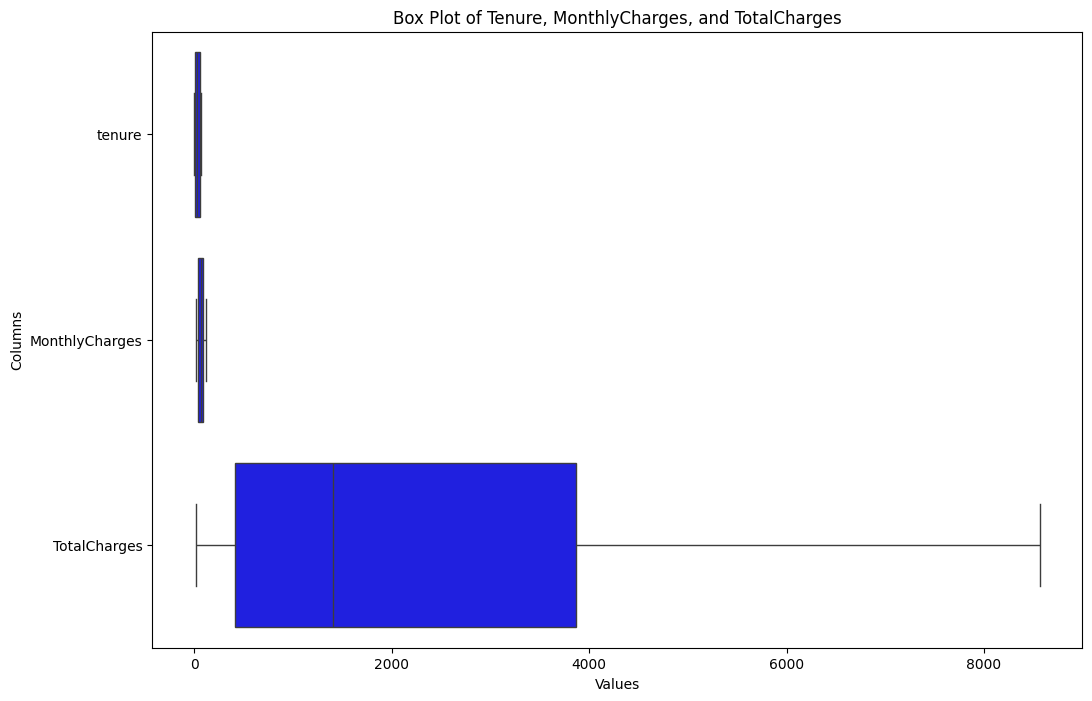

In [12]:
#Check for Outliers
numerical_cols = train_data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.boxplot(data=numerical_cols, orient='h', color='blue')
plt.title('Box Plot of Tenure, MonthlyCharges, and TotalCharges')
plt.xlabel('Values')
plt.ylabel('Columns')
plt.show()


In [13]:
# Print Outliers
outliers = numerical_cols[(np.abs(numerical_cols - numerical_cols.mean()) > (3*numerical_cols.std()))]
print(outliers)


      tenure  MonthlyCharges  TotalCharges
0        NaN             NaN           NaN
1        NaN             NaN           NaN
2        NaN             NaN           NaN
3        NaN             NaN           NaN
4        NaN             NaN           NaN
...      ...             ...           ...
2995     NaN             NaN           NaN
2996     NaN             NaN           NaN
2997     NaN             NaN           NaN
2998     NaN             NaN           NaN
2999     NaN             NaN           NaN

[3000 rows x 3 columns]


In [14]:
#Check for unique values

unique_values = train_data.nunique()
print(unique_values)


customerID          3000
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          2
InternetService        3
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1198
TotalCharges        2893
Churn                  2
dtype: int64


In [15]:
#Check for duplicates

duplicates = train_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [27]:
rows, cols = train_data.shape
print(f"Number of rows: {rows}, Number of columns: {cols}")


Number of rows: 3000, Number of columns: 21


In [28]:
# Training Dataset content verification

train_data.sample()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1816,1663-MHLHE,Male,False,False,False,1,True,False,No,None,...,None,None,None,None,Month-to-month,False,Mailed check,19.200001,19.200001,False


**Evaluation data**

In [29]:
#Check Data Type

evaluation_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [32]:
#Summary Statistics for numerical column
evaluation_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,2043.000000,2043.000000,2043.000000
mean,0.168380,32.649046,64.712555
std,0.374295,24.376248,29.970010
min,0.000000,0.000000,18.550000
25%,0.000000,9.000000,35.825000
50%,0.000000,30.000000,70.250000
75%,0.000000,55.000000,89.625000
max,1.000000,72.000000,118.350000


In [33]:
# Check Missing value
missing_values = evaluation_data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


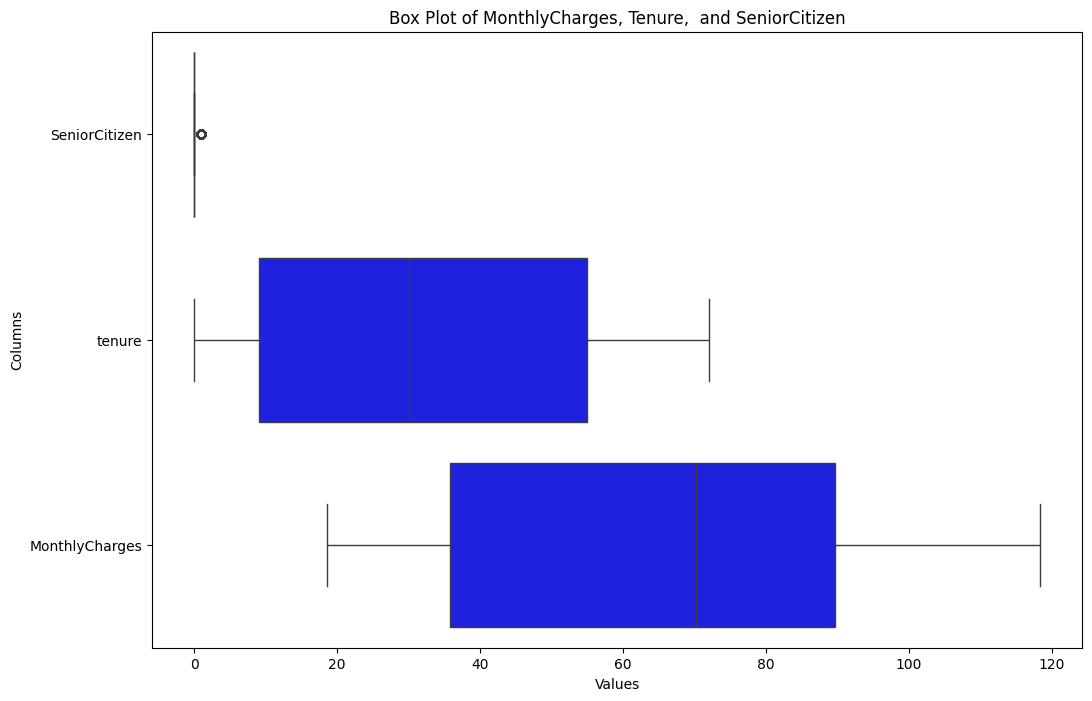

In [36]:
#Check for Outliers
numerical_col = evaluation_data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.boxplot(data=numerical_col, orient='h', color='blue')
plt.title('Box Plot of MonthlyCharges, Tenure,  and SeniorCitizen')
plt.xlabel('Values')
plt.ylabel('Columns')
plt.show()


In [37]:
# Print Outliers
outliers = numerical_col[(np.abs(numerical_col - numerical_col.mean()) > (3*numerical_col.std()))]
print(outliers)


      SeniorCitizen  tenure  MonthlyCharges
0               NaN     NaN             NaN
1               NaN     NaN             NaN
2               NaN     NaN             NaN
3               NaN     NaN             NaN
4               NaN     NaN             NaN
...             ...     ...             ...
2038            NaN     NaN             NaN
2039            NaN     NaN             NaN
2040            NaN     NaN             NaN
2041            NaN     NaN             NaN
2042            NaN     NaN             NaN

[2043 rows x 3 columns]


In [39]:
#Check for unique values

unique_values = evaluation_data.nunique()
print(unique_values)

customerID          2043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1029
TotalCharges        1991
Churn                  2
dtype: int64


In [40]:
#Check for duplicates

duplicates = evaluation_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [53]:
#Check the shape

rows, cols = evaluation_data.shape
print(f"Number of rows: {rows}, Number of columns: {cols}")

Number of rows: 2043, Number of columns: 21


In [43]:
# Evaluation Dataset content verification

evaluation_data.sample()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1797,8725-JEDFD,Male,0,No,No,27,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,69.05,1793.25,No


**Test Data**

In [44]:
#Check Data Type

test_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

In [45]:
#Summary Statistics for numerical column
test_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,2000.000000,2000.000000,2000.000000
mean,0.161500,31.853000,63.933325
std,0.368084,24.632677,30.136858
min,0.000000,0.000000,18.250000
25%,0.000000,8.000000,34.250000
50%,0.000000,27.000000,69.800000
75%,0.000000,55.000000,89.275000
max,1.000000,72.000000,118.750000


In [46]:
# Check Missing value
missing_values = test_data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


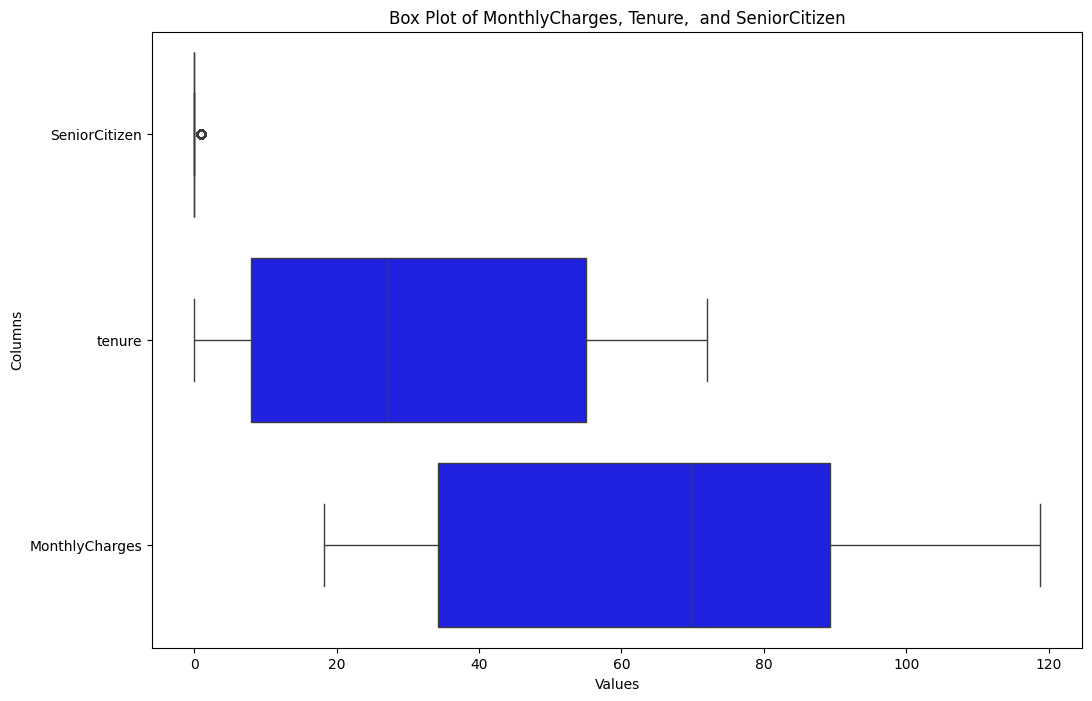

In [48]:
#Check for Outliers
numerical_column = test_data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.boxplot(data=numerical_column, orient='h', color='blue')
plt.title('Box Plot of MonthlyCharges, Tenure,  and SeniorCitizen')
plt.xlabel('Values')
plt.ylabel('Columns')
plt.show()


In [49]:
# Print Outliers
outliers = numerical_column[(np.abs(numerical_column - numerical_column.mean()) > (3*numerical_column.std()))]
print(outliers)

      SeniorCitizen  tenure  MonthlyCharges
0               NaN     NaN             NaN
1               NaN     NaN             NaN
2               NaN     NaN             NaN
3               NaN     NaN             NaN
4               NaN     NaN             NaN
...             ...     ...             ...
1995            NaN     NaN             NaN
1996            NaN     NaN             NaN
1997            NaN     NaN             NaN
1998            NaN     NaN             NaN
1999            NaN     NaN             NaN

[2000 rows x 3 columns]


In [50]:
#Check for unique values

unique_values = test_data.nunique()
print(unique_values)

customerID          2000
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges       986
TotalCharges        1930
dtype: int64


In [51]:
#Check for duplicates

duplicates = test_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [52]:
# Check the shape

rows, cols = test_data.shape
print(f"Number of rows: {rows}, Number of columns: {cols}")

Number of rows: 2000, Number of columns: 20


In [56]:
# Test Dataset content verification

evaluation_data.sample()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1692,8591-NXRCV,Female,0,No,No,41,Yes,Yes,DSL,Yes,...,Yes,Yes,No,Yes,Month-to-month,Yes,Bank transfer (automatic),74.65,3090.65,No


**Cleaning of the Three(3) Datasets**